In [12]:
import os
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("Warning: GPU not available, using CPU.")

PROJECT_ROOT = Path.cwd() if (Path.cwd() / "checkpoints").exists() else Path.cwd().parent
WEIGHT_PATH = PROJECT_ROOT / "checkpoints" / "mae_pretrain_vit_base.pth"


Using device: cuda
GPU: NVIDIA GeForce RTX 4090
GPU Memory: 23.99 GB


In [13]:
def load_image(image_path, size=224):
    tfm = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor()
    ])
    img = Image.open(image_path).convert("RGB")
    return tfm(img).unsqueeze(0)


In [14]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.proj = nn.Linear(dim, dim)
        
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.act = nn.GELU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim * mlp_ratio))
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


In [15]:
class MAEEncoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.):
        super().__init__()
        self.patch_size = patch_size
        num_patches = (img_size // patch_size) ** 2
        
        class PatchEmbed(nn.Module):
            def __init__(self):
                super().__init__()
                self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
            def forward(self, x):
                return self.proj(x)
        
        self.patch_embed = PatchEmbed()
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.blocks = nn.ModuleList([Block(embed_dim, num_heads, mlp_ratio) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        
    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        return x


In [16]:
def load_mae_encoder(weight_path, device='cpu'):
    model = MAEEncoder().to(device)
    
    ckpt = torch.load(weight_path, map_location=device)
    if 'model' in ckpt:
        state_dict = ckpt['model']
    elif 'state_dict' in ckpt:
        state_dict = ckpt['state_dict']
    else:
        state_dict = ckpt
    
    for prefix in ["module.", "model.", "net."]:
        state_dict = {k[len(prefix):] if k.startswith(prefix) else k: v for k, v in state_dict.items()}
    
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    return model


In [17]:
encoder = load_mae_encoder(WEIGHT_PATH, device)

image_path = PROJECT_ROOT / "notebook" / "data" / "sample_image.jpg"
image = load_image(image_path).to(device)

with torch.no_grad():
    features = encoder(image)
    cls_feature = features[:, 0]
    patch_features = features[:, 1:]
    
print(f"Input shape: {image.shape}")
print(f"CLS feature: {cls_feature.shape}")
print(f"Patch features: {patch_features.shape}")


C:\Users\YJ\AppData\Local\Temp\ipykernel_57128\3415373311.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(weight_path, map_location=device)


Input shape: torch.Size([1, 3, 224, 224])
CLS feature: torch.Size([1, 768])
Patch features: torch.Size([1, 196, 768])


In [18]:
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

data_dir = PROJECT_ROOT / "data"
data_dir.mkdir(exist_ok=True)

full_train = datasets.CIFAR10(root=str(data_dir), train=True, download=True, 
                               transform=transforms.Compose([
                                   transforms.Resize((224, 224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ]))
test_dataset = datasets.CIFAR10(root=str(data_dir), train=False, download=True,
                                 transform=transforms.Compose([
                                     transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ]))

train_size = int(0.9 * len(full_train))
val_size = len(full_train) - train_size
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
print(f"Classes: {test_dataset.classes}")


Files already downloaded and verified
Files already downloaded and verified
Train: 45000, Val: 5000, Test: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
class MAEClassifier(nn.Module):
    def __init__(self, encoder, num_classes=10, freeze_encoder=True):
        super().__init__()
        self.encoder = encoder
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False
        self.head = nn.Linear(768, num_classes)
        
    def forward(self, x):
        features = self.encoder(x)
        cls_token = features[:, 0]
        return self.head(cls_token)

classifier = MAEClassifier(encoder, num_classes=10, freeze_encoder=True).to(device)
optimizer = torch.optim.Adam(classifier.head.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
criterion = nn.CrossEntropyLoss()


In [31]:
def train_classifier(model, train_loader, val_loader, optimizer, criterion, epochs=3):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            train_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
        
        train_acc = 100. * correct / total
        
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        val_acc = 100. * val_correct / val_total
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%\n")

def eval_classifier(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    acc = 100. * correct / total
    print(f"\nTest Accuracy: {acc:.2f}%")
    return acc

train_classifier(classifier, train_loader, val_loader, optimizer, criterion, epochs=200)
test_acc = eval_classifier(classifier, test_loader)

print("\n" + "="*60)
print("Sample Predictions")
print("="*60)
classifier.eval()
test_images, test_labels = next(iter(test_loader))
test_images, test_labels = test_images[:5].to(device), test_labels[:5]

with torch.no_grad():
    outputs = classifier(test_images)
    probs = F.softmax(outputs, dim=1)
    predicted = outputs.argmax(dim=1)

for i in range(5):
    gt_class = test_dataset.classes[test_labels[i]]
    pred_class = test_dataset.classes[predicted[i]]
    confidence = probs[i][predicted[i]].item() * 100
    print(f"Image {i+1}: GT={gt_class:>10s}, Pred={pred_class:>10s}, Confidence={confidence:.2f}%")


Epoch 1/200:  73%|███████▎  | 1024/1407 [01:08<00:25, 14.86it/s, loss=0.8395, acc=71.11%]


KeyboardInterrupt: 

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_classification(images, labels, predictions, probs, classes, num_images=8):
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.flatten()
    
    images = images.cpu()
    for i in range(min(num_images, len(images))):
        img = images[i].permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].axis('off')
        
        gt_label = classes[labels[i]]
        pred_label = classes[predictions[i]]
        confidence = probs[i][predictions[i]].item() * 100
        
        color = 'green' if labels[i] == predictions[i] else 'red'
        axes[i].set_title(f'GT: {gt_label}\nPred: {pred_label}\n{confidence:.1f}%', 
                         color=color, fontsize=10)
    
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / "notebook" / "results" / "classification_results.png", dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: classification_results.png")

classifier.eval()
test_images, test_labels = next(iter(test_loader))
test_images = test_images[:8]
test_labels = test_labels[:8]

with torch.no_grad():
    outputs = classifier(test_images.to(device))
    probs = F.softmax(outputs, dim=1)
    predictions = outputs.argmax(dim=1).cpu()

visualize_classification(test_images, test_labels, predictions, probs.cpu(), 
                        test_dataset.classes, num_images=8)


Saved: classification_results.png


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def create_detection_sample(size=224, num_boxes=3):
    img = torch.rand(3, size, size)
    boxes = []
    labels = []
    for _ in range(num_boxes):
        x1, y1 = np.random.randint(0, size-50, 2)
        w, h = np.random.randint(30, 70, 2)
        boxes.append([x1, y1, x1+w, y1+h])
        labels.append(np.random.randint(0, 10))
        img[:, y1:y1+h, x1:x1+w] = torch.rand(3, 1, 1) * 0.5 + 0.5
    return img, torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels)

class MAEDetector(nn.Module):
    def __init__(self, encoder, num_classes=10, freeze_encoder=True):
        super().__init__()
        self.encoder = encoder
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False
        self.bbox_head = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, 4)
        )
        self.class_head = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        features = self.encoder(x)
        patch_features = features[:, 1:]
        pooled = patch_features.mean(dim=1)
        bbox = self.bbox_head(pooled)
        cls = self.class_head(pooled)
        return bbox, cls

detector = MAEDetector(encoder, num_classes=10, freeze_encoder=True).to(device)

img, boxes, labels = create_detection_sample()
img_batch = img.unsqueeze(0).to(device)

with torch.no_grad():
    pred_boxes, pred_cls = detector(img_batch)
    
print(f"Predicted bbox: {pred_boxes[0].cpu().numpy()}")
print(f"Predicted class: {pred_cls[0].argmax().item()}")
print(f"Ground truth bbox: {boxes[0].numpy()}")
print(f"Ground truth class: {labels[0].item()}")


Predicted bbox: [ 0.11231165  0.10033666 -0.04017836  0.03464301]
Predicted class: 9
Ground truth bbox: [ 62.  37. 107.  83.]
Ground truth class: 5


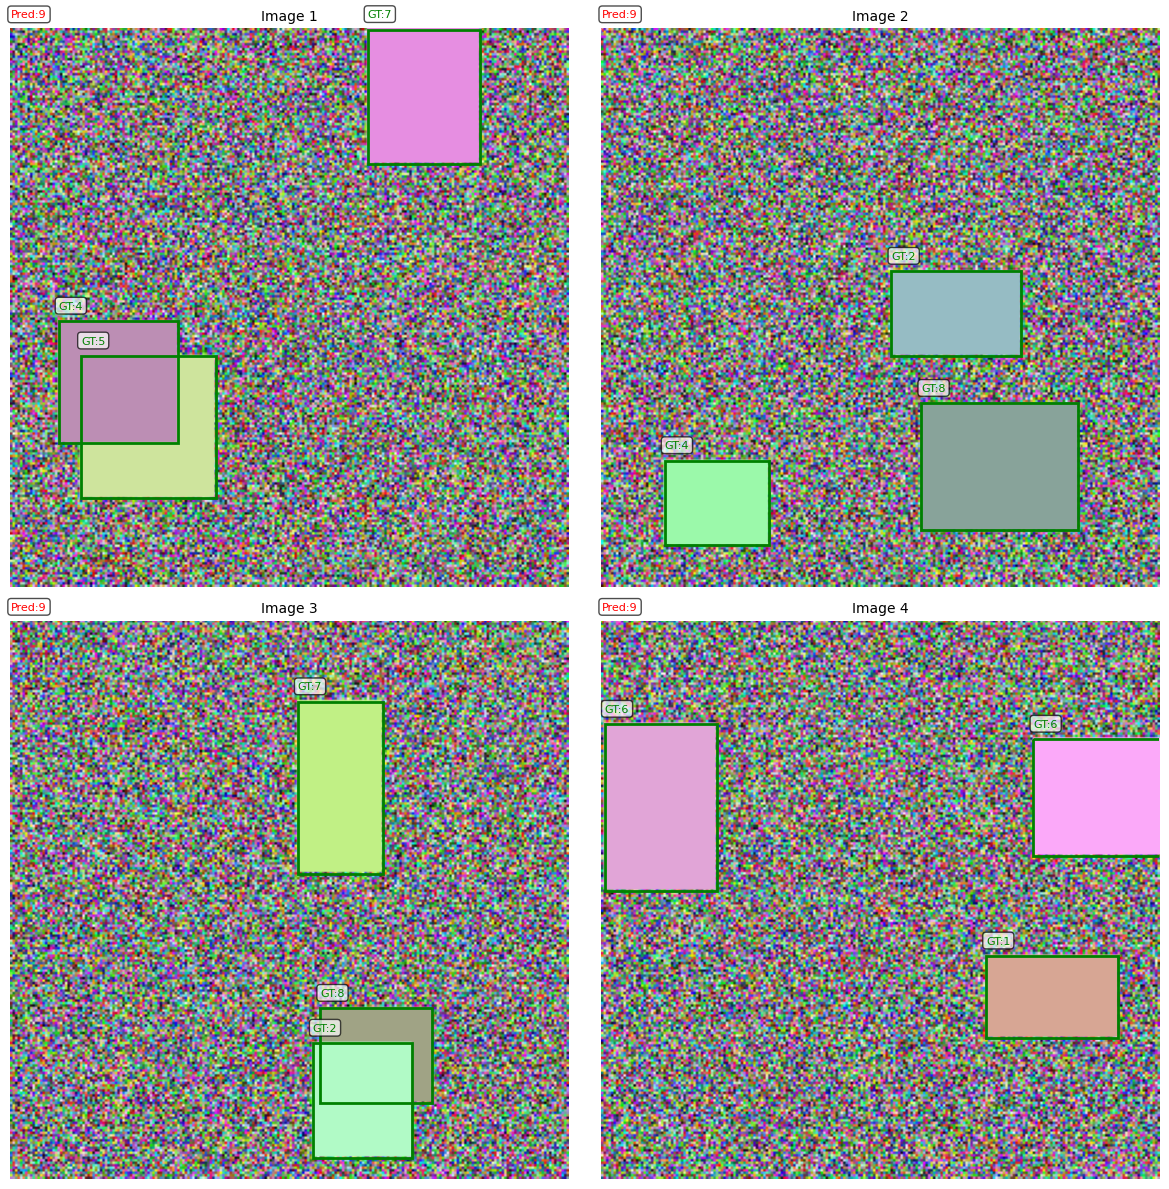

Saved: detection_results.png


In [28]:
import matplotlib.patches as mpatches

def visualize_detection(images, gt_boxes_list, gt_labels_list, pred_boxes, pred_labels, num_images=4):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()
    
    for i in range(min(num_images, len(images))):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].axis('off')
        
        if i < len(gt_boxes_list):
            for box, label in zip(gt_boxes_list[i], gt_labels_list[i]):
                x1, y1, x2, y2 = box
                w, h = x2 - x1, y2 - y1
                rect = mpatches.Rectangle((x1, y1), w, h, linewidth=2, 
                                         edgecolor='green', facecolor='none', label='GT')
                axes[i].add_patch(rect)
                axes[i].text(x1, y1-5, f'GT:{label}', color='green', fontsize=8, 
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        if i < len(pred_boxes):
            x1, y1, x2, y2 = pred_boxes[i].cpu().numpy()
            w, h = x2 - x1, y2 - y1
            rect = mpatches.Rectangle((x1, y1), w, h, linewidth=2, 
                                     edgecolor='red', facecolor='none', label='Pred')
            axes[i].add_patch(rect)
            pred_class = pred_labels[i].argmax().item()
            axes[i].text(x2, y1-5, f'Pred:{pred_class}', color='red', fontsize=8,
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        axes[i].set_title(f'Image {i+1}', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / "notebook" / "results" / "detection_results.png", dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: detection_results.png")

images_list = []
gt_boxes_list = []
gt_labels_list = []

for _ in range(4):
    img, boxes, labels = create_detection_sample()
    images_list.append(img)
    gt_boxes_list.append(boxes)
    gt_labels_list.append(labels)

images_batch = torch.stack(images_list).to(device)

with torch.no_grad():
    pred_boxes, pred_cls = detector(images_batch)

visualize_detection(images_list, gt_boxes_list, gt_labels_list, pred_boxes, pred_cls, num_images=4)


In [29]:
def create_segmentation_sample(size=224, num_classes=5):
    img = torch.rand(3, size, size)
    mask = torch.zeros(size, size, dtype=torch.long)
    for c in range(1, num_classes):
        x, y = np.random.randint(0, size-60, 2)
        w, h = np.random.randint(40, 80, 2)
        mask[y:y+h, x:x+w] = c
        img[:, y:y+h, x:x+w] = torch.tensor([c/num_classes, 0.5, 1-c/num_classes]).view(3, 1, 1)
    return img, mask

class MAESegmenter(nn.Module):
    def __init__(self, encoder, num_classes=5, freeze_encoder=True):
        super().__init__()
        self.encoder = encoder
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False
        self.seg_head = nn.Sequential(
            nn.ConvTranspose2d(768, 256, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, num_classes, kernel_size=2, stride=2)
        )
        
    def forward(self, x):
        features = self.encoder(x)
        patch_features = features[:, 1:]
        B, N, C = patch_features.shape
        H = W = int(N ** 0.5)
        patch_features = patch_features.transpose(1, 2).reshape(B, C, H, W)
        seg_map = self.seg_head(patch_features)
        return seg_map

segmenter = MAESegmenter(encoder, num_classes=5, freeze_encoder=True).to(device)

img, mask = create_segmentation_sample()
img_batch = img.unsqueeze(0).to(device)

with torch.no_grad():
    seg_output = segmenter(img_batch)
    pred_mask = seg_output.argmax(dim=1)[0]
    
print(f"Input shape: {img_batch.shape}")
print(f"Segmentation output: {seg_output.shape}")
print(f"Predicted mask: {pred_mask.shape}")
print(f"Ground truth mask: {mask.shape}")
print(f"Unique predicted classes: {pred_mask.unique().cpu().numpy()}")
print(f"Unique GT classes: {mask.unique().numpy()}")


Input shape: torch.Size([1, 3, 224, 224])
Segmentation output: torch.Size([1, 5, 224, 224])
Predicted mask: torch.Size([224, 224])
Ground truth mask: torch.Size([224, 224])
Unique predicted classes: [1]
Unique GT classes: [0 1 2 3 4]


C:\Users\YJ\AppData\Local\Temp\ipykernel_57128\2136532987.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', 10)
C:\Users\YJ\AppData\Local\Temp\ipykernel_57128\2136532987.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


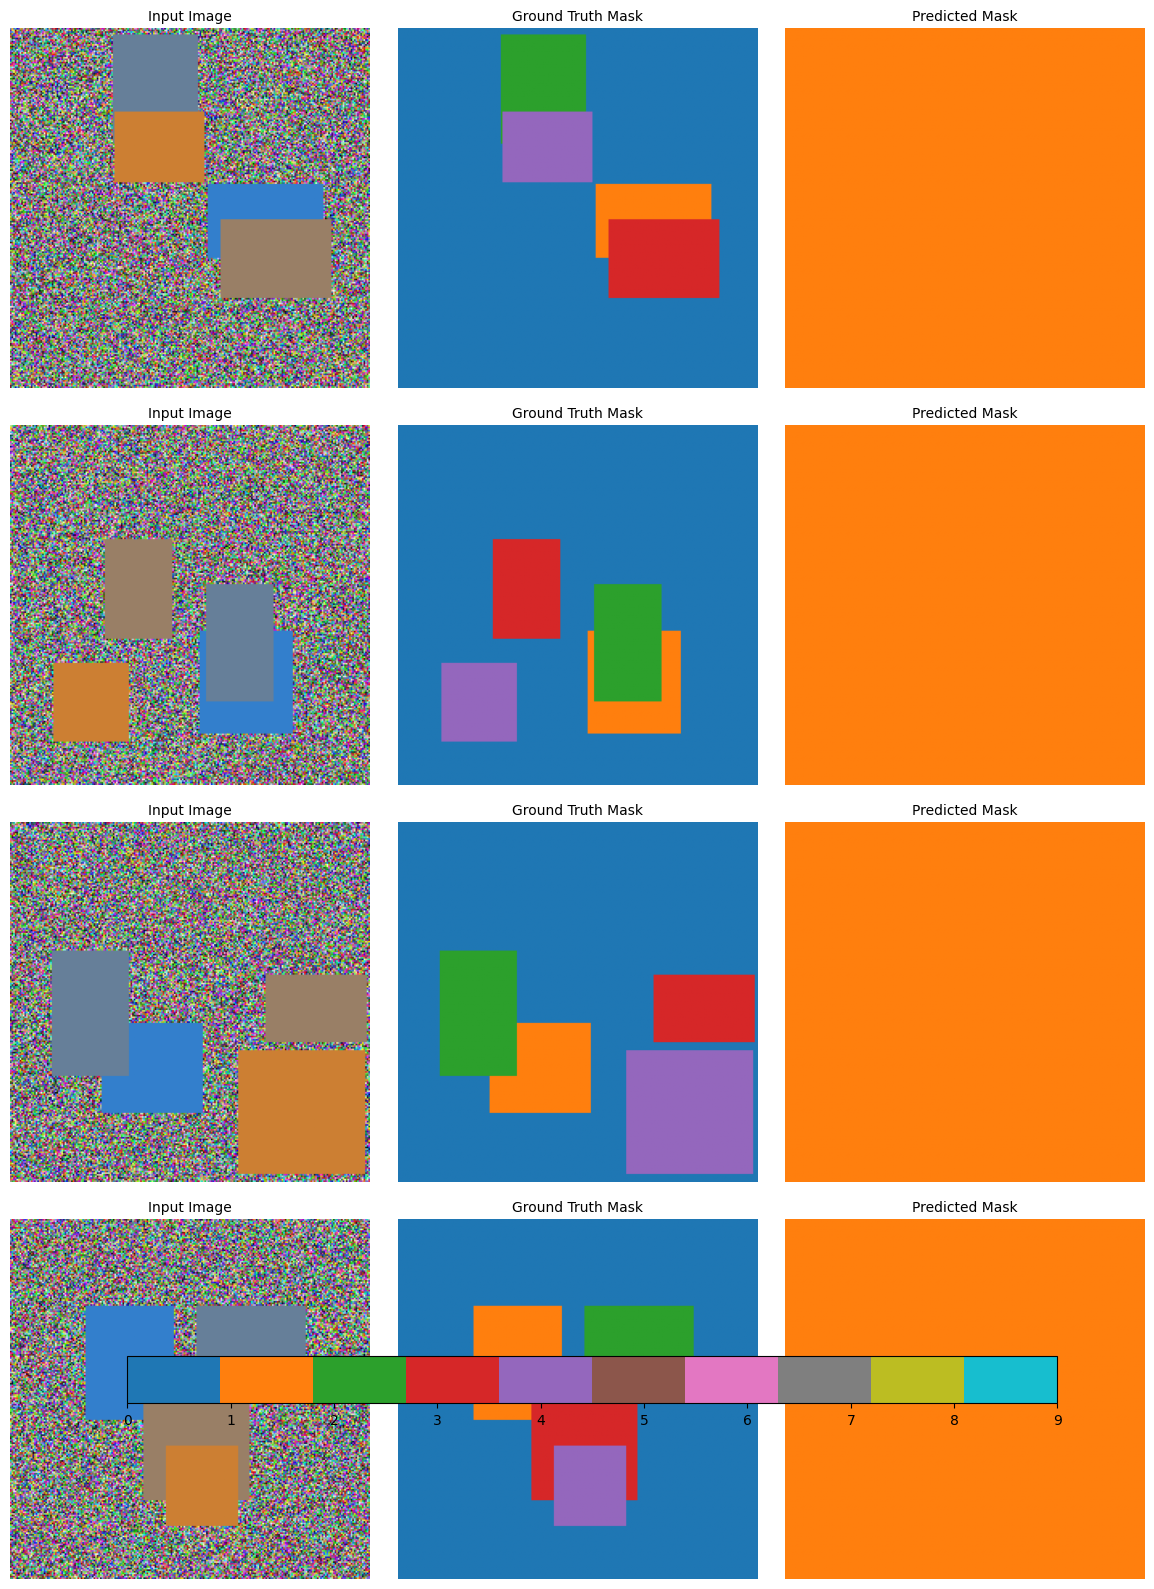

Saved: segmentation_results.png


In [30]:
def visualize_segmentation(images, gt_masks, pred_masks, num_images=4):
    fig, axes = plt.subplots(num_images, 3, figsize=(12, 4*num_images))
    
    cmap = plt.cm.get_cmap('tab10', 10)
    
    for i in range(min(num_images, len(images))):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Input Image', fontsize=10)
        axes[i, 0].axis('off')
        
        gt_mask = gt_masks[i].cpu().numpy()
        axes[i, 1].imshow(gt_mask, cmap=cmap, vmin=0, vmax=9)
        axes[i, 1].set_title('Ground Truth Mask', fontsize=10)
        axes[i, 1].axis('off')
        
        pred_mask = pred_masks[i].cpu().numpy()
        im = axes[i, 2].imshow(pred_mask, cmap=cmap, vmin=0, vmax=9)
        axes[i, 2].set_title('Predicted Mask', fontsize=10)
        axes[i, 2].axis('off')
    
    plt.colorbar(im, ax=axes, orientation='horizontal', pad=0.01, fraction=0.05)
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / "notebook" / "results" / "segmentation_results.png", dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: segmentation_results.png")

images_list = []
gt_masks_list = []

for _ in range(4):
    img, mask = create_segmentation_sample()
    images_list.append(img)
    gt_masks_list.append(mask)

images_batch = torch.stack(images_list).to(device)
gt_masks_batch = torch.stack(gt_masks_list)

with torch.no_grad():
    seg_output = segmenter(images_batch)
    pred_masks = seg_output.argmax(dim=1)

visualize_segmentation(images_list, gt_masks_batch, pred_masks, num_images=4)
